### Initiation

In [31]:
os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/Python Scripts/LabScripts')
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For statistics
from scipy import stats

# For curve fitting
from scipy.optimize import curve_fit

# Seaborn plotting
import seaborn as sns

# Import trackArrayTools
from trackArrayTools import *

# Import for correlation analysis
from scipy import signal

#rSNAPsim_IP
cwd = os.getcwd()  # get current working director
os.chdir('../rSNAPsim_IP/rSNAPsim_IP/') # assume rSNAPsim_IP is  one directory up
import rSNAPsim_IP as rss_IP #importing rSNAPsim.
os.chdir(cwd) # change back to original current directory (the directory this file is in)

#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

### Set current working directory, track array filenames, and basic parameters

In [32]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/'
video_3D_filename_path = 'C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/'
beads_path = 'X:/_FiXie/Charlotte/_90m movies for particle tracking/20180707_TA_translation assay_90m images/Beads/'
video_3D_filename = 'TA02_90m.tif'

In [33]:
# For display, so z and xy are shown properly when viewing track array
z_renorm = z_pixel_size/xy_pixel_size  

#  Track array filenames should be the following:
track_array_filename = 'Tracks_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
track_filename = track_array_filename[:-15] + '.csv'
[track_array_filename, track_filename]

['Tracks_TA02_90m_crop_pad_5.tif', 'Tracks_TA02_90m.csv']

### Creating Track Array (only done once using original 3D video and tracks)

In [ ]:
# Loading the figure with beads so track array can be registered
# Dimension 1 is the number of channel. Red and Green. # Dimension 2 is the x axis. # Dimension 3 is the y axis.
figWithBeads = beads_path + 'Beads01.tif'
im_beads = io.imread(figWithBeads) # reading the image

In [ ]:
# Using rSNAPSim to get the homography matrix to align the green/blue channels with red
temp_obj_beads = rss_IP.BeadsAlignment(im_beads)
[my_homography,positions_green,positions_red] = temp_obj_beads.make_beads_alignment()  # !!! Adjusted Luis' code to spit this info out

In [ ]:
# Check that the homography matrix is working:
my_homography_inverse = np.linalg.inv(my_homography)  # This is the transformation we use to shift green to red
print('[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]' )
for i in np.arange(len(positions_green)):
    g0=positions_green[i]
    g=np.dot(my_homography_inverse,[positions_green[i,0],positions_green[i,1],1])[0:2]  # Correct green/blue
    r0=positions_red[i]
    r=np.dot(my_homography,[positions_red[i,0],positions_red[i,1],1])[0:2]  # What you'll do: shift red to green
    print([np.linalg.norm(g0-r0),np.linalg.norm(g0-r),np.linalg.norm(g-r0)]) # Check corrections

In [ ]:
# Read in the original 3D video 
video_3D = imread(video_3D_filename_path+video_3D_filename)

In [ ]:
# Read in the tracking file that corresponds to the original 3D video
tracks = pd.read_csv(video_3D_filename_path+track_filename) 
# tracks.head()

In [ ]:
viewer = napari.Viewer()
viewer.add_image(video_3D[0::10,:,:,:,0],name='red',blending="additive", scale=[z_renorm,1,1])
viewer.add_image(video_3D[0::10,:,:,:,1],name='green',blending="additive", scale=[z_renorm,1,1])
viewer.add_image(video_3D[0::10,:,:,:,2],name='blue',blending="additive", scale=[z_renorm,1,1])
viewer.add_tracks(tracks[['TRACK_ID','POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']].values, name="TRACK_IDs")

In [ ]:
create_track_array_video(working_directory, track_array_filename, video_3D[0::10], 
                             tracks, crop_pad, xy_pixel_size, z_pixel_size, homography = my_homography)

### Track Array bg-correction one-by-one: best-z projection + 2D disk/donut

In [ ]:
# Just in case you want to update trackArrayTools without having to restart Kernel
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

# Choose which track array you want to work with:
working_directory ='C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/'
track_array_filename = 'Tracks_TL21_crop_pad_5.tif'

# The corresponding tracking file should be in the same directory and have the following filename: 
track_filename = track_array_filename[:-15] + '.csv'

# Read in the track array video 
track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

# Read in tracks as a "dataframes (df)"
track_array_df = pd.read_csv(working_directory + track_filename)

# Make sure color channels are the last dimension of the track array
dims = list(track_array_vid.shape)
if len(dims) != 3:     # check if just a single channel video
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)
    track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

In [ ]:
# Step 0: Create the track array object:
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

In [ ]:
# Step 0.5: check if z's are offset in different channels
my_offset = [0,-1,-1]  ### For 3-color, could be [0,-1,-1]; BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)

# Check with napari
max = np.max(arr_bg,axis=(0,1,2)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(arr_bg,[z_renorm,1,1],int_range=my_range,layer=[capsule_mask[:,:,:,0],capsule_mask[:,:,:,1]])

In [ ]:
# Step 1: Best-z projection using offset from above
my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # best-z mask w/ offset
best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +

# Check with napari
max = np.max(best_z,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(best_z,[1,1],int_range=my_range)

In [ ]:
# Step 2: Subtract background in donut rings from max projection  
best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))

# Check with napari and show donut mask
max = np.max(best_z_bg,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
napari_viewer(best_z_bg,[1,1],int_range=my_range,layer=[ta.donut_mask_2D(5,1)])

In [ ]:
# Output background-subtracted and max-z projected track array 
output_filename_path = working_directory + track_array_filename[0:-4] + '_bestz_bg-sub.tif'
io.imsave(output_filename_path,
        best_z_bg, 
        resolution=(1/xy_pixel_size,1/xy_pixel_size))
output_filename_path

### Track Array bg-correction batch processing: best_z projection + 2D disk/donut

In [ ]:
# Loop everything above, if desired:
working_directory = working_directory ='C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/'
vids = ['TA02_90m.tif','TA04_90m.tif','TA07_90m.tif','TA05.tif','TA06.tif',
        'TA09.tif','TA11.tif','TA12.tif','TA13.tif','TA49_51m11s.tif','TA50.tif',
        'TL01_60m.tif','TL06.tif','TL07.tif','TL09.tif','TL10.tif','TL02.tif','TL04_2.tif', 
        'TL06-1.tif','TL10_90m.tif','TL20_2.tif','TL21.tif']
my_offset = [0,-1,-1]  ### BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
for vs in vids:
    # Get track array video and tracking files:
    track_array_filename = 'Tracks_'+vs[0:-4]+'_crop_pad_5.tif'
    track_filename = track_array_filename[:-15] + '.csv'

    # Read in the track array video 
    track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

    # Read in tracks as a "dataframes (df)"
    track_array_df = pd.read_csv(working_directory + track_filename)

    # Make sure color channels are the last dimension of the track array
    dims = list(track_array_vid.shape)
    if len(dims) != 3:     # check if just a single channel video
        n_channels = min(dims)
        n_channels_index = dims.index(n_channels)
        track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

    # Step 0: make the track array object
    ta = TrackArray(track_array_vid, track_array_df, crop_pad)
    
    # Step 1: Now do best-z projection with offset
    my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
    best_z = ta.mask_projection(np.clip(ta.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +
    
    # Step 2: Subtract background in donut rings from max projection  
    best_z_bg = ta.local_background_subtract(best_z,ta.donut_mask_2D(5,1))

    # Output background-subtracted and max-z projected track array 
    output_filename_path = working_directory + track_array_filename[0:-4] + '_bestz_bg-sub.tif'
    io.imsave(output_filename_path,
            best_z_bg, 
            resolution=(1/xy_pixel_size,1/xy_pixel_size))
    
output_filename_path

### Concatentate all track arrays of interest

In [34]:
# del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
# from trackArrayTools import *

In [35]:
# Specify files you want to read in
working_directory = 'C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/'
vids_TA = ['TA02_90m.tif','TA04_90m.tif','TA07_90m.tif','TA05.tif','TA06.tif',
        'TA09.tif','TA11.tif','TA12.tif','TA13.tif','TA49_51m11s.tif','TA50.tif']
vids_TL = ['TL01_60m.tif','TL06.tif','TL07.tif','TL09.tif','TL10.tif','TL02.tif','TL04_2.tif', 
        'TL06-1.tif','TL10_90m.tif','TL20_2.tif','TL21.tif']
replicates = []

crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
#track_array_filenames = ['Tracks_' + videos[:-4] + '_crop_pad_' + 
#                          str(crop_pad) + '.tif' for videos in vids]
track_array_filenames_TA = ['Tracks_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_TA]
track_array_filenames_TL = ['Tracks_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bestz_bg-sub.tif' for videos in vids_TL]

In [36]:
# Read in all track array videos and corresponding tracking files:
track_array_vids_TA = [imread(working_directory + i) for i in track_array_filenames_TA]  # Read in track array .tif file
track_files_TA = [pd.read_csv(working_directory + 'Tracks_' + videos[:-4]+'.csv') for videos in vids_TA]

track_array_vids_TL = [imread(working_directory + i) for i in track_array_filenames_TL]  # Read in track array .tif file
track_files_TL = [pd.read_csv(working_directory + 'Tracks_' + videos[:-4]+'.csv') for videos in vids_TL]

# Concatentate the tracking files:
tracks_all_TA = pd.concat(track_files_TA, axis=0, sort=False) 
tracks_all_TL = pd.concat(track_files_TL, axis=0, sort=False) 

# Concatenate the tracking_array_vids:
track_array_all_TA = concat_crop_array_vids(track_array_vids_TA)
track_array_all_TL = concat_crop_array_vids(track_array_vids_TL)

# Make large, single track array:
ta_TA = TrackArray(track_array_all_TA, tracks_all_TA.reset_index(), crop_pad)
ta_TL = TrackArray(track_array_all_TL, tracks_all_TL.reset_index(), crop_pad)

In [37]:
# Renormalize intensity by multiplicative factors row-by-row so 3 standard deviations from mean = 5000
renorm_arr_TA = ta_TA.int_renorm_by_row(ta_TA.arr, 3, 5000)
renorm_arr_TL = ta_TL.int_renorm_by_row(ta_TL.arr, 3, 5000)

In [17]:
napari_viewer(ta_TA.moving_avg(track_array_vids_TA[6],3),[1,1],int_range=[[0,1000],[160,3500],[0,1300]],
              layer=[ta_TA.donut_mask_2D(3,1)])

In [98]:
# View the tracks:
napari_viewer(ta_TA.moving_avg(ta_TA.arr,3),[1,1],int_range=[[0,1000],[160,3500],[0,1300]],
              layer=[ta_TA.donut_mask_2D(3,1)])

In [ ]:
# View the tracks[:]
napari_viewer(ta_TL.moving_avg(ta_TL.arr,3),[1,1],int_range=[[0,1000],[160,3500],[0,1300]],
              layer=[ta_TL.donut_mask_2D(3,1)])

In [97]:
# View the tracks:
napari_viewer(ta_TA.moving_avg(renorm_arr_TA,3),[1,1],int_range=[[1500,8000],[1500,8000],[1500,8000]],
              layer=[ta_TA.donut_mask_2D(3,1)])

In [ ]:
napari_viewer(ta_TA.moving_avg(track_array_vids_TA[3],1),[1,1])

### Global analysis of intensities:

In [38]:
os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/Plots/')

In [39]:
# Find positions of rows of dataframe where first timepoint is not zero, which is dt for each row
dt_list=list(ta_TA.df[ta_TA.df['POSITION_T']==1]['POSITION_T_REAL'].values)

In [40]:
# Just for this dataset, since different rows correspond to different movies with different frame rates, below 
# I find the different delta_ts (time between frames) for each row:
delta_ts_TA = ta_TA.df[(ta_TA.df['FRAMES']==1)]['POSITION_T_REAL'].values #!!! Change to POSITION_T
delta_ts_TL_1 = ta_TL.df[(ta_TL.df['FRAMES']==1)]['POSITION_T_REAL'].values #!!! Change to POSITION_T
delta_ts_TL_2 = ta_TL.df[(ta_TL.df['FRAMES']==1)]['REAL_T'].values #!!! Change to POSITION_T
clean_TL_1 =  [x for x in delta_ts_TL_1 if str(x) != 'nan']
clean_TL_2 =  [x for x in delta_ts_TL_2 if str(x) != 'nan']
delta_ts_TL = np.array(clean_TL_1+clean_TL_2)
[delta_ts_TA,delta_ts_TL]

[array([100. , 100. , 100. , 100. , 100. ,  88. ,  88. ,  88. ,  88. ,
         88. ,  88. ,  88. ,  88. ,  88. ,  88. ,  88. ,  88. ,  88. ,
         88. ,  88. ,  88. ,  88. ,  88. ,  94.7,  94.7,  94.7]),
 array([ 94.7,  89. ,  89. ,  89. ,  89. ,  89. ,  89. ,  89. ,  89. ,
         89. ,  89. ,  89. ,  89. , 100. , 100. , 100. , 100. , 100. ,
        100. , 100. , 100. , 100. ])]

In [41]:
# Make dataframes from the measurements of intensities in 2D disk masks:
# Choose channel names:
chs = ['mRNA Int. (a.u.)', 'Trnl. Int. (a.u.)', 'Tether Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]
pchs = ['% Change '+ c for c in chs]

binned_TA_raw = ta_TA.binned_array(ta_TA.arr,delta_ts_TA,-2)
binned_TL_raw = ta_TL.binned_array(ta_TL.arr,delta_ts_TL,-2)

df_ta_raw = ta_TA.measure_intensity_in_mask_df(binned_TA_raw, np.array([ta_TA.disk_mask_2D(3)]), 
            dt=1, start_frame=5, renorm_frames=[0,7], file=0, replicate=0,exp='Ago2',
                                          ch_names = chs)
df_tl_raw = ta_TL.measure_intensity_in_mask_df(binned_TL_raw, np.array([ta_TL.disk_mask_2D(3)]), 
            dt=1, start_frame=5, renorm_frames=[0,7], file=0, replicate=0,exp='\u03B2-gal',
                                          ch_names = chs) 
# Concatenate everything together:
df_all_raw = pd.concat([df_tl_raw,df_ta_raw], axis = 0, sort=False)
df_all_raw.to_csv('RawIntensityScatterPlotData.csv')
df_all_raw.head()

,Crop Row,Frame,Original time (min),Time (min),mRNA Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRNA Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),% Change mRNA Int. (a.u.),% Change Trnl. Int. (a.u.),% Change Tether Int. (a.u.),Expt.,Rep.,File
0,0.0,0.0,0.0,-5.0,179.110345,1031.651724,215.961207,0.532430,0.919651,0.240801,0.001663,0.000692,0.000072,β-gal,0,0
1,0.0,1.0,1.0,-4.0,306.931897,2060.155172,2385.054310,0.912398,1.836495,2.659380,0.002850,0.001381,0.000796,β-gal,0,0
2,0.0,2.0,2.0,-3.0,330.171552,2014.943103,2448.586207,0.981481,1.796191,2.730219,0.003066,0.001351,0.000817,β-gal,0,0
3,0.0,3.0,3.0,-2.0,227.150862,1114.597414,3343.810345,0.675237,0.993591,3.728411,0.002109,0.000747,0.001116,β-gal,0,0
4,0.0,4.0,4.0,-1.0,139.836207,809.573276,-16.845690,0.415683,0.721682,-0.018783,0.001299,0.000543,-0.000006,β-gal,0,0


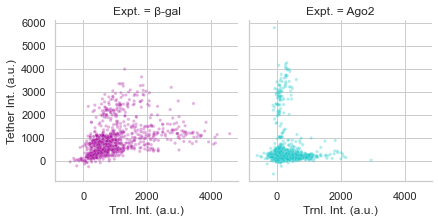

In [22]:
sns.set_style("whitegrid") # [(1.0, 0.7099607843137254, 0), (0.65, 0, 0.60998), (0, 0.77, 0.78)]
g=sns.relplot(x=chs[1], y=chs[2], col="Expt.", hue="Expt.",
            sizes=(40, 80), alpha=.3, s=10,palette=[(.65,.0,0.60998),(0,0.77,0.78)],legend=False,
            height=3, data=df_all_raw,aspect=1)

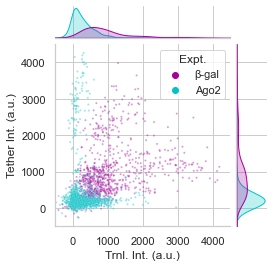

In [23]:
sns.set_style('whitegrid')
grid=sns.jointplot(data=df_all_raw, x=chs[1],y=chs[2], hue="Expt.",
                    palette=[(.65,0,.60998),(0,0.77,0.78)],alpha=0.4,s=4,legend=True,xlim=[-500,4500],ylim=[-500,4500])
grid.fig.set_figwidth(3.5)
grid.fig.set_figheight(3.5)
plt.savefig('Ago2-Betagal-ScatterPlot.svg', format = 'svg', dpi=300)

### Global Analysis of time series on row-by-row renormalized data:

In [24]:
# Just for this dataset, since different rows correspond to different movies with different frame rates, below 
# I find the different delta_ts (time between frames) for each row:
delta_ts_TA = ta_TA.df[(ta_TA.df['FRAMES']==1)]['POSITION_T_REAL'].values #!!! Change to POSITION_T
delta_ts_TL_1 = ta_TL.df[(ta_TL.df['FRAMES']==1)]['POSITION_T_REAL'].values #!!! Change to POSITION_T
delta_ts_TL_2 = ta_TL.df[(ta_TL.df['FRAMES']==1)]['REAL_T'].values #!!! Change to POSITION_T
clean_TL_1 =  [x for x in delta_ts_TL_1 if str(x) != 'nan']
clean_TL_2 =  [x for x in delta_ts_TL_2 if str(x) != 'nan']
delta_ts_TL = np.array(clean_TL_1+clean_TL_2)
[delta_ts_TA,delta_ts_TL]

[array([100. , 100. , 100. , 100. , 100. ,  88. ,  88. ,  88. ,  88. ,
         88. ,  88. ,  88. ,  88. ,  88. ,  88. ,  88. ,  88. ,  88. ,
         88. ,  88. ,  88. ,  88. ,  88. ,  94.7,  94.7,  94.7]),
 array([ 94.7,  89. ,  89. ,  89. ,  89. ,  89. ,  89. ,  89. ,  89. ,
         89. ,  89. ,  89. ,  89. , 100. , 100. , 100. , 100. , 100. ,
        100. , 100. , 100. , 100. ])]

In [25]:
# Now I bin the track array, so all columns are in same binned times (times considered the same to -2 significant digits)
# Thus, bins are time 0 = [0,100), time 1 = [100,200), ...
binned_TA = ta_TA.binned_array(renorm_arr_TA,delta_ts_TA,-2)
binned_TL = ta_TL.binned_array(renorm_arr_TL,delta_ts_TL,-2)

In [26]:
# Make dataframes from the measurements of intensities in 2D disk masks:
# Choose channel names:
chs = ['mRNA Int. (a.u.)', 'Trnl. Int. (a.u.)', 'Tether Int. (a.u.)']
rchs = ['Renorm. '+ c for c in chs]

df_ta = ta_TA.measure_intensity_in_mask_df(binned_TA, np.array([ta_TA.disk_mask_2D(3)]), 
            dt=1, start_frame=0, renorm_frames=[0,3], file=0, replicate=0,exp='Ago2',
                                          ch_names = chs)
df_tl = ta_TL.measure_intensity_in_mask_df(binned_TL, np.array([ta_TL.disk_mask_2D(3)]), 
            dt=1, start_frame=0, renorm_frames=[0,3], file=0, replicate=0,exp='\u03B2-gal',
                                          ch_names = chs) 
# Concatenate everything together:
df_all = pd.concat([df_ta,df_tl], axis = 0, sort=False)

# Rolling average in case you want to use it:
df_all['Time (minutes)'] = df_all['Time (min)']*100/60
df_all['Roll Avg.'+'Time (min)'] = df_all['Time (min)'].rolling(window=3).mean()
df_all['Roll Avg.'+chs[0]] = df_all[rchs[0]].rolling(window=3).mean()
df_all['Roll Avg.'+chs[1]] = df_all[rchs[1]].rolling(window=3).mean()
df_all['Roll Avg.'+chs[2]] = df_all[rchs[2]].rolling(window=3).mean()
df_all.to_csv('DoubleRenormalizationLongTracksData.csv')
df_all

,Crop Row,Frame,Original time (min),Time (min),mRNA Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRNA Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),...,% Change Trnl. Int. (a.u.),% Change Tether Int. (a.u.),Expt.,Rep.,File,Time (minutes),Roll Avg.Time (min),Roll Avg.mRNA Int. (a.u.),Roll Avg.Trnl. Int. (a.u.),Roll Avg.Tether Int. (a.u.)
0,0.0,0.0,0.0,0.0,3741.840170,2763.083740,1734.702290,1.483722,1.721557,1.613163,...,0.000641,0.000634,Ago2,0,0,0.000000,NaN,NaN,NaN,NaN
1,0.0,1.0,1.0,1.0,3137.332902,3158.418004,1630.897046,1.244022,1.967873,1.516631,...,0.000733,0.000596,Ago2,0,0,1.666667,NaN,NaN,NaN,NaN
2,0.0,2.0,2.0,2.0,2925.016929,2659.585938,2523.979981,1.159834,1.657072,2.347142,...,0.000617,0.000922,Ago2,0,0,3.333333,1.0,1.295859,1.782167,1.825646
3,0.0,3.0,3.0,3.0,3484.240115,3303.207144,907.561400,1.381578,2.058084,0.843975,...,0.000766,0.000332,Ago2,0,0,5.000000,2.0,1.261811,1.894343,1.569249
4,0.0,4.0,4.0,4.0,3038.103725,2399.902934,1571.642955,1.204675,1.495275,1.461529,...,0.000557,0.000574,Ago2,0,0,6.666667,3.0,1.248696,1.736811,1.550882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,21.0,49.0,49.0,49.0,1323.617817,283.510694,494.137078,0.432420,0.124458,0.220284,...,0.000042,0.000070,β-gal,0,0,81.666667,48.0,0.432425,0.187287,0.282385
1205,21.0,50.0,50.0,50.0,840.600486,563.170413,829.093686,0.274620,0.247225,0.369607,...,0.000083,0.000118,β-gal,0,0,83.333333,49.0,0.387215,0.219514,0.300101
1206,21.0,51.0,51.0,51.0,940.950330,453.230252,713.811433,0.307404,0.198963,0.318214,...,0.000067,0.000101,β-gal,0,0,85.000000,50.0,0.338148,0.190215,0.302702
1207,21.0,52.0,52.0,52.0,881.468921,683.363070,605.768382,0.287972,0.299988,0.270049,...,0.000101,0.000086,β-gal,0,0,86.666667,51.0,0.289999,0.248725,0.319290


In [29]:
df_all[df_all['Expt.']=='\u03B2-gal']

,Crop Row,Frame,Original time (min),Time (min),mRNA Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRNA Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),...,% Change Trnl. Int. (a.u.),% Change Tether Int. (a.u.),Expt.,Rep.,File,Time (minutes),Roll Avg.Time (min),Roll Avg.mRNA Int. (a.u.),Roll Avg.Trnl. Int. (a.u.),Roll Avg.Tether Int. (a.u.)
0,0.0,0.0,0.0,0.0,1657.165839,1855.209982,188.069906,0.541388,0.814414,0.083841,...,0.000341,0.000029,β-gal,0,0,0.000000,33.0,0.502977,0.244511,0.789770
1,0.0,1.0,1.0,1.0,2839.797190,3704.758448,2077.025527,0.927748,1.626344,0.925929,...,0.000680,0.000318,β-gal,0,0,1.666667,17.0,0.679477,0.772521,0.861403
2,0.0,2.0,2.0,2.0,3054.815271,3623.453992,2132.352305,0.997994,1.590652,0.950594,...,0.000665,0.000327,β-gal,0,0,3.333333,1.0,0.822377,1.343803,0.653455
3,0.0,3.0,3.0,3.0,2101.646609,2004.370467,2911.958614,0.686598,0.879894,1.298139,...,0.000368,0.000446,β-gal,0,0,5.000000,2.0,0.870780,1.365630,1.058221
4,0.0,4.0,4.0,4.0,1293.793417,1455.848313,-14.670076,0.422676,0.639100,-0.006540,...,0.000267,-0.000002,β-gal,0,0,6.666667,3.0,0.702423,1.036549,0.747398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,21.0,49.0,49.0,49.0,1323.617817,283.510694,494.137078,0.432420,0.124458,0.220284,...,0.000042,0.000070,β-gal,0,0,81.666667,48.0,0.432425,0.187287,0.282385
1205,21.0,50.0,50.0,50.0,840.600486,563.170413,829.093686,0.274620,0.247225,0.369607,...,0.000083,0.000118,β-gal,0,0,83.333333,49.0,0.387215,0.219514,0.300101
1206,21.0,51.0,51.0,51.0,940.950330,453.230252,713.811433,0.307404,0.198963,0.318214,...,0.000067,0.000101,β-gal,0,0,85.000000,50.0,0.338148,0.190215,0.302702
1207,21.0,52.0,52.0,52.0,881.468921,683.363070,605.768382,0.287972,0.299988,0.270049,...,0.000101,0.000086,β-gal,0,0,86.666667,51.0,0.289999,0.248725,0.319290


In [28]:
df_all[df_all['Expt.']=='Ago2']

,Crop Row,Frame,Original time (min),Time (min),mRNA Int. (a.u.),Trnl. Int. (a.u.),Tether Int. (a.u.),Renorm. mRNA Int. (a.u.),Renorm. Trnl. Int. (a.u.),Renorm. Tether Int. (a.u.),...,% Change Trnl. Int. (a.u.),% Change Tether Int. (a.u.),Expt.,Rep.,File,Time (minutes),Roll Avg.Time (min),Roll Avg.mRNA Int. (a.u.),Roll Avg.Trnl. Int. (a.u.),Roll Avg.Tether Int. (a.u.)
0,0.0,0.0,0.0,0.0,3741.840170,2763.083740,1734.702290,1.483722,1.721557,1.613163,...,0.000641,0.000634,Ago2,0,0,0.000000,NaN,NaN,NaN,NaN
1,0.0,1.0,1.0,1.0,3137.332902,3158.418004,1630.897046,1.244022,1.967873,1.516631,...,0.000733,0.000596,Ago2,0,0,1.666667,NaN,NaN,NaN,NaN
2,0.0,2.0,2.0,2.0,2925.016929,2659.585938,2523.979981,1.159834,1.657072,2.347142,...,0.000617,0.000922,Ago2,0,0,3.333333,1.0,1.295859,1.782167,1.825646
3,0.0,3.0,3.0,3.0,3484.240115,3303.207144,907.561400,1.381578,2.058084,0.843975,...,0.000766,0.000332,Ago2,0,0,5.000000,2.0,1.261811,1.894343,1.569249
4,0.0,4.0,4.0,4.0,3038.103725,2399.902934,1571.642955,1.204675,1.495275,1.461529,...,0.000557,0.000574,Ago2,0,0,6.666667,3.0,1.248696,1.736811,1.550882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,25.0,46.0,46.0,46.0,1746.594425,1611.488453,1156.078535,0.692563,1.004048,1.075080,...,0.000346,0.000429,Ago2,0,0,76.666667,45.0,0.773404,0.640512,1.673423
1447,25.0,47.0,47.0,47.0,147.463329,-658.545917,70.110755,0.058472,-0.410311,0.065199,...,-0.000142,0.000026,Ago2,0,0,78.333333,46.0,0.642725,0.423853,1.306933
1448,25.0,48.0,48.0,48.0,737.919293,277.402056,2243.031189,0.292601,0.172837,2.085877,...,0.000060,0.000832,Ago2,0,0,80.000000,47.0,0.347879,0.255525,1.075385
1449,25.0,49.0,49.0,49.0,1004.354609,67.910440,764.601174,0.398249,0.042312,0.711031,...,0.000015,0.000283,Ago2,0,0,81.666667,48.0,0.249774,-0.065054,0.954036


In [ ]:
# View the binned tracks:
napari_viewer(ta_TA.moving_avg(binned_TA,3),[1,1],int_range=[[1500,8000],[1500,8000],[1500,8000]],
              layer=[ta_TA.donut_mask_2D(3,1)])

In [ ]:
# View the binned tracks:
napari_viewer(ta_TL.moving_avg(binned_TL,3),[1,1],int_range=[[1500,8000],[1500,8000],[1500,8000]],
              layer=[ta_TL.donut_mask_2D(3,1)])

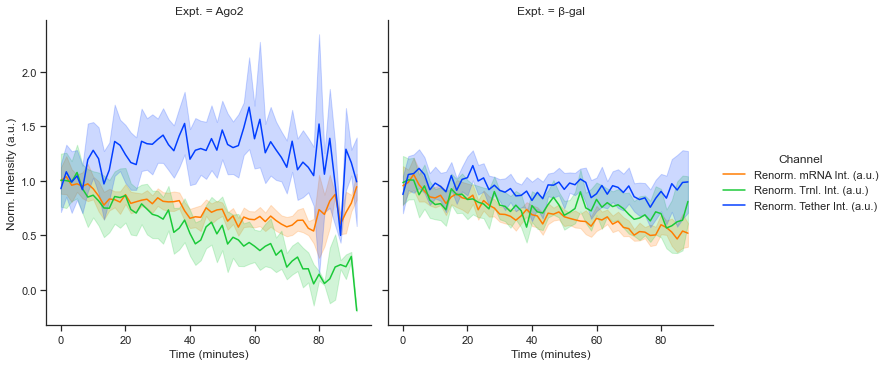

In [104]:
sns.set_style('ticks')
# melt dataframe to plot multiple columns (y-vals) vs a single column (x-vals):
df_melt=pd.melt(df_all, id_vars=['Time (minutes)','Expt.','Rep.','Crop Row'],var_name='Channel', 
                value_name='Norm. Intensity (a.u.)',value_vars=rchs)
# Choose palette, plot, and save:
my_palette = [sns.color_palette("bright")[1],sns.color_palette("bright")[2],sns.color_palette("bright")[0]]
g=sns.relplot(x='Time (minutes)', y='Norm. Intensity (a.u.)', hue='Channel', col='Expt.',
              data = df_melt, kind='line',palette=my_palette,legend=True,aspect=1)

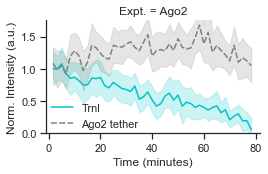

In [105]:
# Choose palette, plot, and save:[(0,0.77,0.78),(.67,.05,.76)]  [(1.0, 0.7099607843137254, 0), (0.65, 0, 0.6099800000000001), (0, 0.77, 0.78)]
my_palette = [(0,0.77,0.78),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y= 'Norm. Intensity (a.u.)', hue='Channel', style='Channel',col='Expt.', 
    data = df_melt[(df_melt['Expt.']=='Ago2')&(df_melt['Channel']!=rchs[0])
                   &(df_melt['Time (minutes)']>0)&(df_melt['Time (minutes)']<48*100/60)], 
              kind='line',palette=my_palette,legend=False,aspect=1.5, height=3.5/1.5)
g.set(xlim=(-1, 49*100/60))
g.set(ylim=(0, 1.75))
plt.legend(['Trnl','Ago2 tether'],loc='lower left', borderaxespad=0., frameon=False)
plt.savefig('Avg-Ago2-LongTracks.svg', format = 'svg', dpi=300)

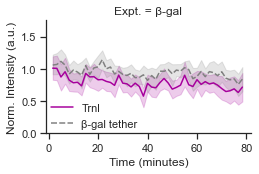

In [106]:
# Choose palette, plot, and save:[(0,0.77,0.78),(.67,.05,.76)] [(1.0, 0.7099607843137254, 0), (0.65, 0, 0.60998), (0, 0.77, 0.78)]
my_palette = [(.65,0,.60998),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y='Norm. Intensity (a.u.)', hue='Channel',style='Channel', col='Expt.', 
        data = df_melt[(df_melt['Expt.']=='\u03B2-gal')&(df_melt['Channel']!=rchs[0]) 
        &(df_melt['Time (minutes)']>0)&(df_melt['Time (minutes)']<48*100/60)], kind='line',
        palette=my_palette,legend=False,aspect=1.5, height=3.5/1.5)
g.set(xlim=(-1, 49*100/60))
g.set(ylim=(0, 1.75))
plt.legend(['Trnl','\u03B2-gal tether'],loc='lower left', borderaxespad=0., frameon=False)
plt.savefig('Avg-BetaGal-LongTracks.svg', format = 'svg', dpi=300)

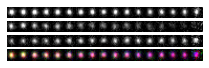

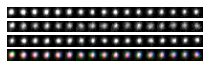

In [107]:
ta_TA.plot_array_avg_row(binned_TA,xlim=[0,50],dx=3,fig_size=(3.5,1),
            int_range=[[0,3500],[0,3500],[0,3500]],out_file='LongTracks-AvgRow-Ago2.png')
ta_TL.plot_array_avg_row(binned_TL,xlim=[0,50],dx=3,fig_size=(3.5,1),
            int_range=[[0,4000],[0,4000],[0,4000]],out_file='LongTracks-AvgRow-BetaGal.png')

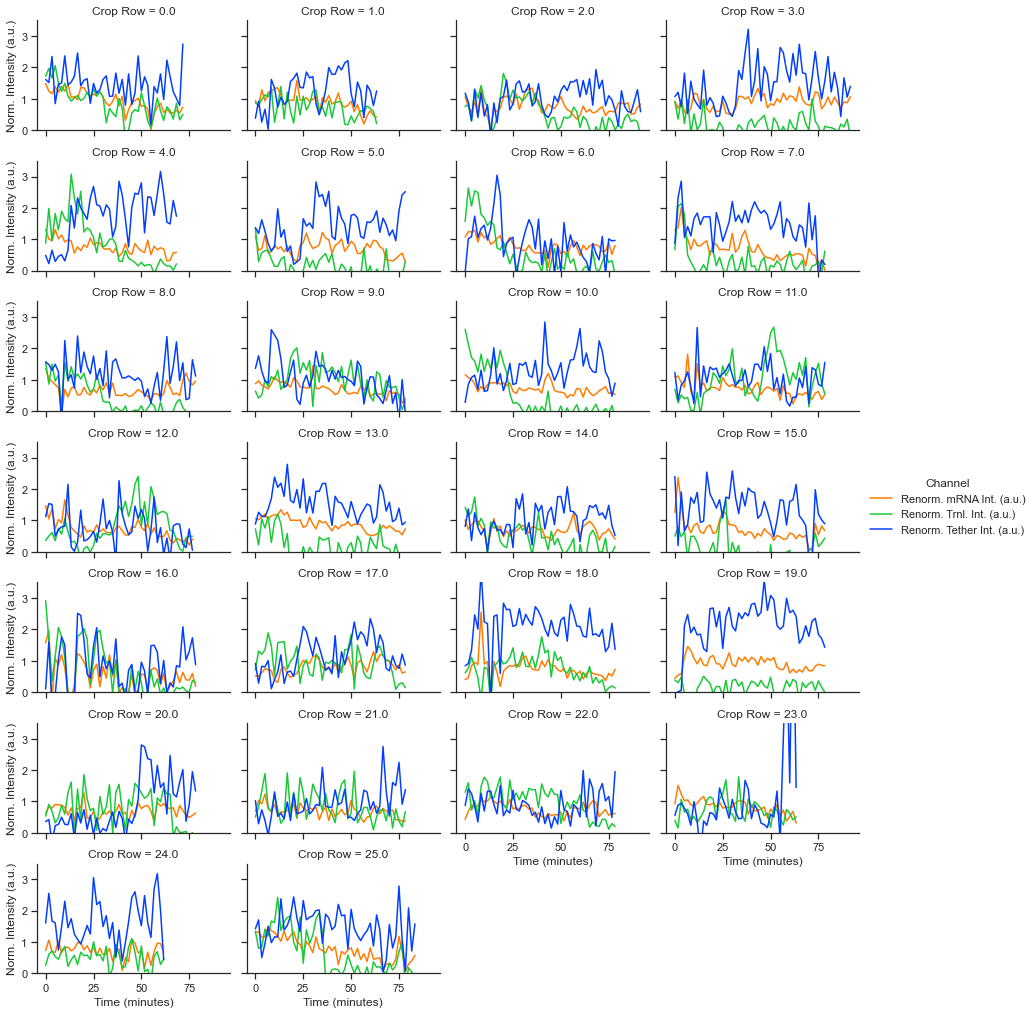

In [108]:
# Check all individual tracks:
my_palette = [sns.color_palette("bright")[1],sns.color_palette("bright")[2],sns.color_palette("bright")[0]]
sns.set_style('ticks')
g=sns.relplot(x='Time (minutes)', y='Norm. Intensity (a.u.)', hue='Channel',col='Crop Row',col_wrap=4,
              data = df_melt[df_melt['Expt.']=='Ago2'], kind='line',palette=my_palette,legend=True,
              aspect=1.5,height=2,ci=None)
g.set(ylim=(0,3.5))

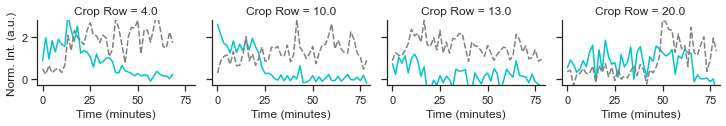

In [109]:
# plot tracks of choice:
df_meltMA=pd.melt(df_all, id_vars=['Time (minutes)','Expt.','Rep.','Crop Row'],var_name='Channel', 
                value_name='Norm. Int. (a.u.)',value_vars=rchs)

# Choose palette, plot, and save:
mycond1 = (df_meltMA['Expt.'] == 'Ago2') & (df_meltMA['Channel'] != rchs[0])
mycond2 = (df_meltMA['Crop Row']==4)|(df_meltMA['Crop Row']==20)|(df_meltMA['Crop Row']==10)|(df_meltMA['Crop Row']==13)
            
my_palette = [(0,0.77,0.78),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y='Norm. Int. (a.u.)', hue='Channel', style='Channel',col='Crop Row',
              data = df_meltMA[mycond1][mycond2], kind='line',
              palette=my_palette,legend=False,aspect=1.5,height = 2.5/1.5)
g.set(ylim=(-.3,2.8))
g.set(xlim=(-3,80))
plt.savefig('Ago2-LongTracks-AntiCor.svg', format = 'svg', dpi=300)

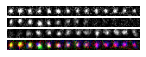

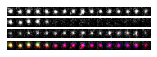

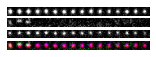

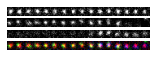

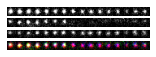

In [110]:
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),4,xlim=[0,42],dx=3,fig_size=(2.4,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_4.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),10,xlim=[0,48],dx=3,fig_size=(2.57,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_10.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),13,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_13.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),20,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_20.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),25,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_25.png')

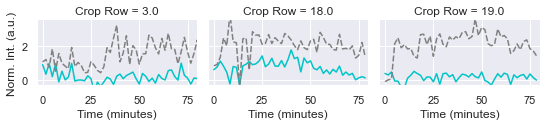

In [49]:
# Sample plot where translation remains low and Ago2 accumulates over time 
# plot tracks of choice:
df_meltMA=pd.melt(df_all, id_vars=['Time (minutes)','Expt.','Rep.','Crop Row'],var_name='Channel', 
                value_name='Norm. Int. (a.u.)',value_vars=rchs)

# Choose palette, plot, and save:
mycond1 = (df_meltMA['Expt.'] == 'Ago2') & (df_meltMA['Channel'] != rchs[0])
mycond2 = (df_meltMA['Crop Row']==3)|(df_meltMA['Crop Row']==19)|(df_meltMA['Crop Row']==18)

my_palette = [(0,0.77,0.78),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y='Norm. Int. (a.u.)', hue='Channel', style='Channel',col='Crop Row',
              data = df_meltMA[mycond1][mycond2], kind='line',
              palette=my_palette,legend=False,aspect=1.5,height = 2.5/1.5)
g.set(ylim=(-.3,3.5))
g.set(xlim=(-3,80))
plt.savefig('Ago2-LongTracks-Track3and19.svg', format = 'svg', dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


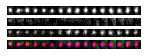

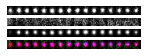

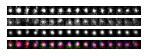

In [50]:
# The plot above:
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),3,xlim=[0,48],dx=3,fig_size=(2.4,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_3.png')
# The plot above:
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),19,xlim=[0,48],dx=3,fig_size=(2.4,0.8),
            int_range=[[0,3000],[-800,4500],[0,4500]],out_file='TA_Crop_Row_19.png')
# The plot above:
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),18,xlim=[0,48],dx=3,fig_size=(2.4,0.8),
            int_range=[[0,3000],[-800,4500],[0,4500]],out_file='TA_Crop_Row_18.png')

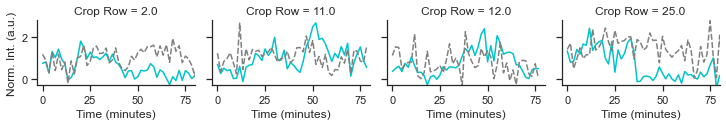

In [52]:
sns.set_style('ticks')
# plot tracks of choice:
df_meltMA=pd.melt(df_all, id_vars=['Time (minutes)','Expt.','Rep.','Crop Row'],var_name='Channel', 
                value_name='Norm. Int. (a.u.)',value_vars=rchs)
# Choose palette, plot, and save:
mycond1 = (df_meltMA['Expt.'] == 'Ago2') & (df_meltMA['Channel'] != rchs[0])
mycond2 = (df_meltMA['Crop Row']==2)|(df_meltMA['Crop Row']==11)|(df_meltMA['Crop Row']==12)|(df_meltMA['Crop Row']==25)
            
my_palette = [(0,0.77,0.78),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y='Norm. Int. (a.u.)', hue='Channel', style='Channel',col='Crop Row',
              data = df_meltMA[mycond1][mycond2], kind='line',
              palette=my_palette,legend=False,aspect=1.5,height = 2.5/1.5)
g.set(ylim=(-.3,2.8))
g.set(xlim=(-3,80))
plt.savefig('Ago2-LongTracks-Bursts.svg', format = 'svg', dpi=300)

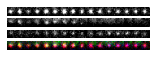

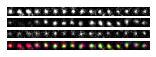

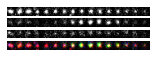

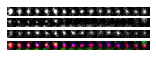

In [28]:
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),2,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_2.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),11,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_11.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),12,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_12.png')
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,3),15,xlim=[0,48],dx=3,fig_size=(2.55,0.8),
            int_range=[[0,3000],[0,4500],[0,4500]],out_file='TA_Crop_Row_15.png')

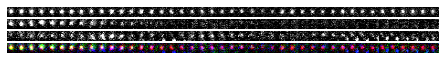

In [29]:
ta_TA.plot_array_row(ta_TA.moving_avg(binned_TA,1),6,xlim=[0,43],dx=1,fig_size=(8,.85),
            int_range=[[0,4000],[0,4500],[0,3500]],out_file='TA_Crop_Row_6.png')

In [36]:
df_all_raw.head()

,Crop Row,Frame,Original time (min),Time (min),mRNA Intensity (a.u.),Trnl. Intensity (a.u.),Tether Intensity (a.u.),Renorm. mRNA Intensity (a.u.),Renorm. Trnl. Intensity (a.u.),Renorm. Tether Intensity (a.u.),% Change mRNA Intensity (a.u.),% Change Trnl. Intensity (a.u.),% Change Tether Intensity (a.u.),Expt.,Rep.,File,Time (minutes)
0,0.0,0.0,0.0,-5.0,179.110345,1031.651724,215.961207,0.532430,0.919651,0.240801,0.001663,0.000692,0.000072,β-gal,0,0,0.000000
1,0.0,1.0,1.0,-4.0,306.931897,2060.155172,2385.054310,0.912398,1.836495,2.659380,0.002850,0.001381,0.000796,β-gal,0,0,1.666667
2,0.0,2.0,2.0,-3.0,330.171552,2014.943103,2448.586207,0.981481,1.796191,2.730219,0.003066,0.001351,0.000817,β-gal,0,0,3.333333
3,0.0,3.0,3.0,-2.0,227.150862,1114.597414,3343.810345,0.675237,0.993591,3.728411,0.002109,0.000747,0.001116,β-gal,0,0,5.000000
4,0.0,4.0,4.0,-1.0,139.836207,809.573276,-16.845690,0.415683,0.721682,-0.018783,0.001299,0.000543,-0.000006,β-gal,0,0,6.666667


In [37]:
chs

['mRNA Int. (a.u.)', 'Trnl. Int. (a.u.)', 'Tether Int. (a.u.)']

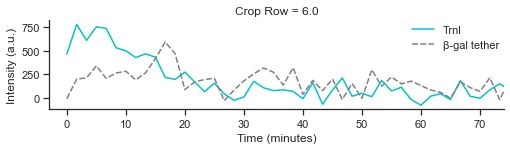

In [41]:
# Plot raw intensities of a sample track (before any renormalization)
sns.set_style('ticks')
# plot tracks of choice:
df_all_raw['Time (minutes)'] = df_all_raw['Original time (min)']*100/60
df_meltMA=pd.melt(df_all_raw, id_vars=['Time (minutes)','Expt.','Rep.','Crop Row'],var_name='Channel', 
                value_name='Intensity (a.u.)',value_vars=chs)
# Choose palette, plot, and save:
mycond1 = (df_meltMA['Expt.'] == 'Ago2') & (df_meltMA['Channel'] != chs[0])
mycond2 = (df_meltMA['Crop Row']==6)
            
my_palette = [(0,0.77,0.78),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y='Intensity (a.u.)', hue='Channel', style='Channel',col='Crop Row',
              data = df_meltMA[mycond1][mycond2], kind='line',
              palette=my_palette,legend=False,aspect=3.5,height = 2.)
#g.set(ylim=(-.3,3.2))
g.set(xlim=(-3,74))
plt.legend(['Trnl','\u03B2-gal tether'],loc='upper right', borderaxespad=0., frameon=False)
plt.savefig('Ago2-SampleFullTrack.svg', format = 'svg', dpi=300)

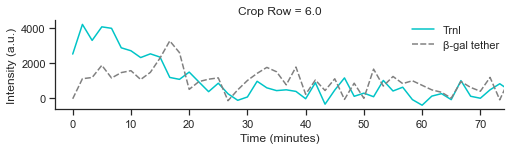

In [44]:
# Same as above, but using renormalized intensities, just for reference:
# Plot raw intensities of a sample track (before any renormalization)
sns.set_style('ticks')
# plot tracks of choice:
df_all_raw['Time (minutes)'] = df_all_raw['Original time (min)']*100/60
df_meltMA=pd.melt(df_all, id_vars=['Time (minutes)','Expt.','Rep.','Crop Row'],var_name='Channel', 
                value_name='Intensity (a.u.)',value_vars=chs)
# Choose palette, plot, and save:
mycond1 = (df_meltMA['Expt.'] == 'Ago2') & (df_meltMA['Channel'] != chs[0])
mycond2 = (df_meltMA['Crop Row']==6)
            
my_palette = [(0,0.77,0.78),(.5,.5,.5)]
g=sns.relplot(x='Time (minutes)', y='Intensity (a.u.)', hue='Channel', style='Channel',col='Crop Row',
              data = df_meltMA[mycond1][mycond2], kind='line',
              palette=my_palette,legend=False,aspect=3.5,height = 2.)
#g.set(ylim=(-.3,3.2))
g.set(xlim=(-3,74))
plt.legend(['Trnl','\u03B2-gal tether'],loc='upper right', borderaxespad=0., frameon=False)
plt.savefig('Ago2-SampleFullTrack.svg', format = 'svg', dpi=300)

In [43]:
median_trnl_sig

1291.780434839624

In [42]:
# Get median intensity for all experiment (since were imaged with same 
# laser powers for green transaltion channel):
alldat = df_all['Trnl. Int. (a.u.)'].values
median_trnl_sig, std_ta = [np.median(alldat),np.std(alldat)]

# Find intensity runs
run_df_TA = ta_TA.find_intensity_runs(df_ta, 'Trnl. Int. (a.u.)', expt = 'Ago2',
                                   th=median_trnl_sig/2, gap=2)
run_df_TL = ta_TL.find_intensity_runs(df_tl, 'Trnl. Int. (a.u.)', expt = '\u03B2-gal',
                                   th=median_trnl_sig/2, gap=2)
df_runs_all = pd.concat([run_df_TA,run_df_TL], axis = 0, sort=False)
run_df_TL.head()

,Run ID,Crop Row,Run Threshhold,Run dt,Run Start Frame,Run End Frame,Run Length,Run Max Length,Left Censored?,Right Censored?,Run Channel,Expt.
0,0.0,0.0,645.890217,94.7,0.0,42.0,42.0,50.0,1.0,0.0,Trnl. Int. (a.u.),β-gal
1,1.0,0.0,645.890217,94.7,46.0,49.0,3.0,50.0,0.0,0.0,Trnl. Int. (a.u.),β-gal
2,2.0,1.0,645.890217,89.0,0.0,47.0,47.0,47.0,1.0,1.0,Trnl. Int. (a.u.),β-gal
3,3.0,2.0,645.890217,89.0,0.0,32.0,32.0,32.0,1.0,1.0,Trnl. Int. (a.u.),β-gal
4,4.0,3.0,645.890217,89.0,0.0,47.0,47.0,47.0,1.0,1.0,Trnl. Int. (a.u.),β-gal


In [ ]:

math.isnan(my_dts[-1])

In [ ]:
import math
new_col1 = []
new_col2 = []
my_cens_list = df_runs_all['Right Censored?'].values
my_end_times = df_runs_all['Run End Frame'].values
my_start_times = df_runs_all['Run Start Frame'].values
my_dts = df_runs_all['Run dt'].values
for i in np.arange(len(my_cens_list)):
    if math.isnan(my_dts[i]):
        my_dt = 100
    else:
        my_dt = my_dts[i]
    new_col2.append(my_dt*my_start_times[i]/60)
    if my_cens_list[i]==1:
        new_col1.append(None)
    else:
        new_col1.append(my_dt*my_end_times[i]/60)
df_runs_all['Start Time Lifeline'] = new_col2
df_runs_all['End Time Lifeline'] = new_col1
df_runs_all
df_runs_all.to_csv('Run_Data.csv')

In [ ]:
df_runs_all['New Col'] = list

In [ ]:
napari_viewer(binned_TA, [1,1],layer = ta_TA.make_run_layer(run_df_TA, ch=2))

In [ ]:
napari_viewer(binned_TL, [1,1],layer = ta_TL.make_run_layer(run_df_TL, ch=2))

In [ ]:
run_ints_df = aligned_runs_df(ta_TA,run_df,df_all,'Tether Int. (a.u.)')
run_ints_df

In [ ]:
df_run_melt=pd.melt(run_ints_df, id_vars=['Aligned Time','Run ID','Run Length','Right Censored?','Left Censored?'],
                    var_name='Channel',value_name='Intensity (a.u.)',value_vars=['Trnl. Int. (a.u.)','Tether Int. (a.u.)'])
df_run_melt

In [ ]:
# Find median tether intensity:
alltetherdat = df_all['Tether Int. (a.u.)'].values
median_tether_sig, std_tether = [np.median(alltetherdat),np.std(alltetherdat)]
[median_tether_sig, std_tether ]

In [ ]:
g=sns.lineplot(data = df_run_melt[(df_run_melt['Right Censored?']==0)&(df_run_melt['Run Length']>1)], 
             x = 'Aligned Time', y = 'Intensity (a.u.)', hue='Channel', estimator='mean')
g.set(ylim=(0,3000))

In [ ]:
g=sns.lineplot(data = df_run_melt[(df_run_melt['Left Censored?']==0)&(df_run_melt['Run Length']>1)], 
             x = 'Aligned Time', y = 'Intensity (a.u.)', hue='Channel', estimator='mean')
g.set(ylim=(0,3000))

In [ ]:
run_ints_df.groupby('Aligned Time').agg({'count','sum','mean','std'})[['Trnl. Int. (a.u.)','Tether Int. (a.u.)']]

In [ ]:
# Choose palette, plot, and save:
sns.set_style('white')
g=sns.relplot(x='Aligned Time (min)', y='Trnl Int. (a.u.)', col = 'Run ID', col_wrap=5,
              data = run_ints_df, kind='line',palette="bright",legend=True,
              aspect=1.5,height=2,ci=None)
g.set(ylim=(0,2000))

In [ ]:
# Check auto- and cross-correlation of the renormalized signals
ac_list=[]
cc_list=[]
#'\u03B2-gal'
myi=[4,10,13,20]
myi=np.arange(ta_TA.n_tracks())
for i in myi:
    sig1 = df_all[(df_all['Crop Row']==i)&(df_all['Expt.']=='Ago2')]['Trnl. Int. (a.u.)'].values
    sig2 = df_all[(df_all['Crop Row']==i)&(df_all['Expt.']=='Ago2')]['Tether Int. (a.u.)'].values
    global_mean_1 = np.mean(df_all['Renorm. Trnl. Int. (a.u.)'])
    global_mean_2 = np.mean(df_all['Renorm. Tether Int. (a.u.)'])
    mycc = list_correlate(sig1,sig2)#, mean1 = global_mean_1, mean2 = global_mean_2)
    myac = list_correlate(sig1,sig1)#, mean1 = global_mean_1, mean2 = global_mean_1)
    my_times = np.arange(2*len(sig1)-1)-len(sig1)+1
    df_ac = pd.DataFrame(np.transpose(np.array([my_times,myac])),
                         columns=['Time (min)', 'Autocorrelation'])
    df_cc = pd.DataFrame(np.transpose(np.array([my_times,mycc])),
                         columns=['Time (min)', 'Cross correlation'])
    ac_list.append(df_ac)
    cc_list.append(df_cc)
ac_results = pd.concat(ac_list)
cc_results = pd.concat(cc_list)
g=sns.lineplot(data=ac_results, x="Time (min)", y="Autocorrelation")
g=sns.lineplot(data=cc_results, x="Time (min)", y="Cross correlation")
g.set(xlim=(-30,30))
g.set(ylim=(-2,6))

In [ ]:
def aligned_runs_df(self, run_df, df_all, coi):
    '''
    Highlights regions of track array that correspond to runs annotated in run_df (which is a dataframe that is the output 
    of the find_intensity_runs command. ch (default 0) is an optional argument taht specifies the channel the layer corresponds
    to. 
    '''
    n_tracks = self.n_tracks()
    crops = self.crops()
    my_crop_layer = np.zeros(crops.shape)  # make a layer to mark the runs
    my_crop_layer_c = np.moveaxis(my_crop_layer, -1, 0)
    n_channels = self.n_channels()
    col_name = run_df['Run Channel'].unique()[0]
    df_aligned_runs = pd.DataFrame(columns=[col_name,'Time (min)'])
    for i in np.arange(n_tracks):
        start_frames = run_df[run_df['Crop Row']==i]['Run Start Frame'].values.astype('int')
        end_frames = run_df[run_df['Crop Row']==i]['Run End Frame'].values.astype('int')
        dts = run_df[run_df['Crop Row']==i]['Run dt'].values
        n_run = run_df[run_df['Crop Row']==i]['Run ID'].values
        r_cen = run_df[run_df['Crop Row']==i]['Right Censored?'].values
        l_cen = run_df[run_df['Crop Row']==i]['Left Censored?'].values
        expt = run_df[run_df['Crop Row']==i]['Expt.'].values
        run_th  = run_df[run_df['Crop Row']==i]['Run Threshhold'].values
        run_len = run_df[run_df['Crop Row']==i]['Run Length'].values
        for j in np.arange(len(start_frames)):
            start,stop = [start_frames[j], end_frames[j]]
            df_temp = df_all[df_all['Crop Row']==i][[col_name,coi,'Time (min)']][start:stop]
            df_temp['Aligned Time'] = np.arange(stop-start)# dts[j]*
            df_temp['Run ID'] = n_run[j]
            df_temp['Crop Row'] = i
            df_temp['Run Threshhold'] = run_th[j]
            df_temp['Run Threshhold'] = run_th[j]
            df_temp['Run dt'] = dts[j]
            df_temp['Run Start Frame'] = start_frames[j]
            df_temp['Run End Frame'] = end_frames[j]
            df_temp['Run Length'] = run_len[j]
            df_temp['Left Censored?'] = l_cen[j]
            df_temp['Right Censored?'] = r_cen[j]
            df_temp['Run Channel'] = col_name
            df_temp['Expt.'] = expt[j]
            df_aligned_runs = df_aligned_runs.append(df_temp) 
    return df_aligned_runs

In [ ]:
def survival_prob(interval_list, t, t0, tN):
    '''
    1. go through each interval and partition into two lists w/ lengths > t or < t
    2. for those less than t, remove those starting from 0 or ending at last time
    3. calculated probability as length(greater_list)/((length_less_list)+(length_greater_list))
    4. bootstrap?
    '''
    greater_list=[]
    less_list=[]
    for int in interval_list:
        start, stop = int
        if (stop - start) > t:
            greater_list.append(int)
        else: 
            if int[0] != t0 and int[1] != tN:
                less_list.append(int)
    return [greater_list, less_list, len(greater_list)/(len(greater_list)+len(less_list))]

In [ ]:
def zero_runs(a):  # from link
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges.tolist()

def runs_above_threshhold(ta_int,ch,th):
    return [zero_runs(np.where(ta_int[i,:,ch] > th, 0, -1)) for i in np.arange(ta_int.shape[0])]

def mean_run_length(ta_int,ch,th):
    runs = runs_above_threshhold(ta_int,ch,th)
    lengths = [np.diff(runs).flatten() for runs in runs]
    flat_lengths = [item for sublist in lengths for item in sublist]
    return [np.mean(flat_lengths),np.std(flat_lengths)/np.sqrt(len(flat_lengths))]

def median_run_length(ta_int,ch,th):
    runs = runs_above_threshhold(ta_int,ch,th)
    lengths = [np.diff(runs).flatten() for runs in runs]
    flat_lengths = [item for sublist in lengths for item in sublist]
    return [np.median(flat_lengths),np.std(flat_lengths)/np.sqrt(len(flat_lengths))]


def run_lengths_above_threshhold_unflat(ta_int,ch,th):
    runs = runs_above_threshhold(ta_int,ch,th)
    lengths = [np.diff(runs).flatten() for runs in runs]
#    flat_lengths = [item for sublist in lengths for item in sublist]
    return lengths


In [ ]:
[len(my_runs),my_runs[0],len(my_run_lengths),np.max(my_run_lengths),run_array.shape]

In [ ]:
my_ta = ta_TA
renorm_arr = my_ta.int_renorm_by_row(my_ta.moving_avg(my_ta.arr,3), 3, 5000)
my_int = my_ta.int_in_mask(renorm_arr,np.array([my_ta.disk_mask_2D(3)]))
n_frames = my_ta.n_frames()
z_slices = my_ta.z_slices()
crop_dim = my_ta.crop_dim()
n_channels = my_ta.n_channels()

my_runs = runs_above_threshhold(my_int,1,50)
my_runs_from_start = [[runs[0]] for runs in my_runs]
my_runs_from_middle = [runs[1:] for runs in my_runs]

my_run_lengths = run_lengths_above_threshhold(my_int,1,50)
n_runs = len(my_run_lengths)
max_run = np.max(my_run_lengths)

runs_crops = np.zeros((n_runs,n_frames,z_slices,crop_dim,crop_dim,n_channels))
runs_ints = np.zeros((n_runs,n_frames,n_channels))

runs_from_start_crops = np.zeros((n_runs,n_frames,z_slices,crop_dim,crop_dim,n_channels))
runs_from_start_ints = np.zeros((n_runs,n_frames,n_channels))

runs_from_middle_crops = np.zeros((n_runs,n_frames,z_slices,crop_dim,crop_dim,n_channels))
runs_from_middle_ints = np.zeros((n_runs,n_frames,n_channels))

row_index = 0
for rows in np.arange(len(my_runs)):
    for runs in np.arange(len(my_runs[rows])):
        start =  my_runs[rows][runs][0]
        end = my_runs[rows][runs][1]
        runs_crops[row_index,0:(end-start)] = my_ta.crops()[rows,start:end]
        runs_ints[row_index,0:(end-start)] = my_int[rows,start:end]
        row_index = row_index + 1

row_index = 0
for rows in np.arange(len(my_runs_from_start)):
    for runs in np.arange(len(my_runs_from_start[rows])):
        start = 1
        start = my_runs_from_start[rows][runs][0]
        end = my_runs_from_start[rows][runs][1]
        runs_from_start_crops[row_index,0:(end-start)] = my_ta.crops()[rows,start:end]
        runs_from_start_ints[row_index,0:(end-start)] = my_int[rows,start:end]
        row_index = row_index + 1
        
row_index = 0
for rows in np.arange(len(my_runs_from_middle)):
    for runs in np.arange(len(my_runs_from_middle[rows])):
        start = 1
        start = my_runs_from_middle[rows][runs][0]
        end = my_runs_from_middle[rows][runs][1]
        runs_from_middle_crops[row_index,0:(end-start)] = my_ta.crops()[rows,start:end]
        runs_from_middle_ints[row_index,0:(end-start)+4] = my_int[rows,start-4:end]
        row_index = row_index + 1
        
        
        
runs_array = my_ta.crops_to_array(runs_crops)
runs_from_start_array = my_ta.crops_to_array(runs_from_start_crops)
runs_from_middle_array = my_ta.crops_to_array(runs_from_middle_crops)

In [ ]:
[len(runs_ints),len(runs_from_middle_ints)]

In [ ]:
start_rows = np.where(my_ta.df.values[:,1] == 0)   # positions where frame # = 0
delta_ts = np.array([my_ta.df.values[i+1,8] for i in start_rows[0]])  # time at next frame from above, which should be delta_t
delta_ts

In [ ]:
rlt = rluf*delta_ts
run_length_times = np.array([item for sublist in rlt for item in sublist])
run_length_times

In [ ]:
my_time_list = np.arange(0,np.max(run_length_times)+1,1)
my_time_list

In [ ]:
rls=run_length_times
survival0 = np.array([[[sum(i > n for i in rls) for n in my_time_list]]])
survival = np.moveaxis(survival0, -1, 1)
my_intensity_plot(survival/survival[0,0,0],0,channels=[0],ylim=[-.1,1.1],
                      colors=['red'],markers=['o'],labels=['survival'])

In [ ]:
my_arr = runs_from_start_ints
def myfun(n):
    my_intensity_plot(my_arr.clip(0,100000),n,channels=[0,1,2],xlim=[0,50],ylim=[-300,1900],aspect_ratio=1/50,
                      colors=['red','limegreen','mediumblue'],markers=['o','d','v'],labels=['mRNA','TRNL','Ago2'])
interact(myfun,n=(0,len(my_arr)-1,1))

In [ ]:
my_arr = runs_ints
my_arr = runs_from_start_ints
my_arr = runs_from_middle_ints
my_mean_intensity_plot(np.ma.masked_equal(my_arr,0),channels=[1,2],labels=['TRNL','Ago2'],xlim=[-4,50],
               colors=['limegreen','blue'],markers=['s','o'],renorm=False,
                       filename='test.svg',style='seaborn-whitegrid')

In [ ]:
napari_viewer(runs_from_start_array[0],[1,1])

In [ ]:
my_box_plots([run_lengths_above_threshhold(my_int_TL,1,50),
                 run_lengths_above_threshhold(my_int_TA,1,50)],color='lightgreen',notch=True,opacity=.1,
                     style='default',aspect_ratio=1/10,x_ticks=['TL','TA'],
                     axes_labels=['Tethering construct','TRNL run lengths (frames)'],filename='test.svg')

In [ ]:
median_run_length(my_int_TA,1,50)

In [ ]:
[median_run_length(my_int_TL,1,50),median_run_length(my_int_TA,1,50)]

In [ ]:
my_box_plots([run_lengths_above_threshhold(my_int_TL,2,50),
                 run_lengths_above_threshhold(my_int_TA,2,50)],color='lightblue',notch=True,opacity=.1,
                     style='default',aspect_ratio=1/10,x_ticks=['TL','TA'],
                     axes_labels=['Tethering construct','Ago2 run lengths (frames)'],filename='test.svg')

In [ ]:
[median_run_length(my_int_TA,2,50),median_run_length(my_int_TL,2,50)]

In [ ]:
my_box_plots([run_lengths_above_threshhold(my_int_TL,0,50),
                 run_lengths_above_threshhold(my_int_TA,0,50)],color='lightcoral',notch=True,opacity=.1,
                     style='default',aspect_ratio=1/10,x_ticks=['TL','TA'],
                     axes_labels=['Tethering construct','mRNA run lengths (frames)'],filename='test.svg')

In [ ]:
[median_run_length(my_int_TA,0,50),median_run_length(my_int_TL,0,50)]

### Functions

In [ ]:
def my_scatter_plots(ints, **kwargs):

    channels = kwargs.get('channels', [0,1,2,3,4,5]) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    colors = kwargs.get('colors', ['tab:red', 'tab:green', 'tab:blue','tab:orange','tab:purple'])
    markers = kwargs.get('markers', ['o','s','v','^','d'])
    filename = kwargs.get('filename', 'none')
    style = kwargs.get('style', 'seaborn-whitegrid')
    axeslabels = kwargs.get('axeslabels',['ch1','ch2','ch3','ch4','ch5'])
    aspect_ratio = kwargs.get('aspect_ratio',0)

    fig, ax = plt.subplots()

    plt.style.use(style)

    for i in np.arange(len(ints)):
        n_channels = ints[i].shape[-1]
        n_frames = ints[i].shape[-2]
        int_c = np.moveaxis(ints[i],-1,0)
        x1 = int_c[channels[0]].flatten()
        y1 = int_c[channels[1]].flatten()
        correlation = stats.pearsonr(x1, y1)
        legend = 'mean = (' + str(round(np.mean(x1))) + ',' +str(round(np.mean(y1))) +')\n'\
        + 'pearson = ' + str(round(correlation[0],2)) +'  p-val ='\
        + str(np.format_float_scientific(correlation[1],unique=False,precision=1))
        ax.scatter(x1, y1, c=colors[i],label=legend,alpha=0.3, edgecolors='none')

    ax.set_xlabel(axeslabels[0])
    ax.set_ylabel(axeslabels[1])
    #ax.set_title('Title')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])

    plt.legend(bbox_to_anchor=(1.05, 1.00), loc='upper left', borderaxespad=0.)
    ax.grid(True)
    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio)
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300) 
    plt.show()

In [ ]:
def my_scatter_plot(int, **kwargs):
    
    n_channels = int.shape[-1]
    n_frames = int.shape[-2]
    int_c = np.moveaxis(int,-1,0)
    
    channels = kwargs.get('channels', [i for i in np.arange(n_channels)]) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    colors = kwargs.get('colors', ['tab:red', 'tab:green', 'tab:blue','tab:orange','tab:purple'])
    markers = kwargs.get('markers', ['o','s','v','^','d'])
    filename = kwargs.get('filename', 'none')
    style = kwargs.get('style', 'seaborn-whitegrid')
    axeslabels = kwargs.get('axeslabels',['ch1','ch2','ch3','ch4','ch5'])
    aspect_ratio = kwargs.get('aspect_ratio',0)

    plt.style.use(style)
    
    fig, ax = plt.subplots()
    x1 = int_c[channels[0]].flatten()
    y1 = int_c[channels[1]].flatten()
    correlation = stats.pearsonr(x1, y1)
    legend = 'mean = (' + str(round(np.mean(x1))) + ',' +str(round(np.mean(y1))) +')\n'\
    + 'pearson = ' + str(round(correlation[0],2)) +'  p-val ='\
    + str(np.format_float_scientific(correlation[1],unique=False,precision=1))
    
    ax.scatter(x1, y1, c=colors[0],label=legend,alpha=0.3, edgecolors='none')

    ax.set_xlabel(axeslabels[0])
    ax.set_ylabel(axeslabels[1])
    #ax.set_title('Title')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])
        
    plt.legend(bbox_to_anchor=(1.05, 1.00), loc='upper left', borderaxespad=0.)
    ax.grid(True)
    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio)
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300)
    plt.show()    

In [ ]:
def my_intensity_plot(int, row, **kwargs):
    """
    Plot track intensities from track array.
    """
    n_channels = int.shape[-1]
    n_frames = int.shape[-2]
    int_c = np.moveaxis(int,-1,0)
        
    channels = kwargs.get('channels', [i for i in np.arange(n_channels)]) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    colors = kwargs.get('colors', ['tab:red', 'tab:green', 'tab:blue','tab:orange','tab:purple'])
    markers = kwargs.get('markers', ['o','s','v','^','d'])
    filename = kwargs.get('filename', 'none')
    labels = kwargs.get('labels', ['ch1','ch2','ch3','ch4','ch5'])
    style = kwargs.get('style', 'seaborn-whitegrid')
    aspect_ratio = kwargs.get('aspect_ratio',0)
 
    plt.style.use(style)

    my_int = np.zeros([n_channels, n_frames])    
    fig, ax = plt.subplots()
    t = np.arange(n_frames)
    ch_index = 0
    for ch in channels:
        my_int[ch] = int_c[ch,row]
        ax.plot(t, my_int[ch], color=colors[ch_index], marker=markers[ch_index],label=labels[ch_index])
        ch_index = ch_index + 1
    ax.set(xlabel='frame #', ylabel='Intensity (a.u.)',
    title='Track Intensity vs. time')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio) 
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300)  
    plt.show()
 

In [ ]:
def my_sum_intensity_plot(int, **kwargs):
    """
    Plot track intensities from track array.
    """
    n_channels = int.shape[-1]
    n_frames = int.shape[1]
    int_c = np.moveaxis(int,-1,0)
    
    channels = kwargs.get('channels', [i for i in np.arange(n_channels)]) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    colors = kwargs.get('colors', ['tab:red', 'tab:green', 'tab:blue','tab:orange','tab:purple'])
    markers = kwargs.get('markers', ['o','s','v','^','d'])
    labels = kwargs.get('labels', ['ch1','ch2','ch3','ch4','ch5'])
    renorm = kwargs.get('renorm', False)
    filename = kwargs.get('filename', 'none')
    style = kwargs.get('style', 'seaborn-whitegrid')
    aspect_ratio = kwargs.get('aspect_ratio',0)

    plt.style.use(style)
    
    my_int = np.zeros([n_channels, n_frames])    
    my_sd = np.zeros([n_channels, n_frames]) 
    my_int_renorm = np.zeros([n_channels, n_frames])  
    my_sd_renorm = np.zeros([n_channels, n_frames])
    
    fig, ax = plt.subplots()
    t = np.arange(n_frames)
    ch_index=0
    for ch in channels:
        my_int[ch] = np.sum(int_c[ch],axis=0)
        my_sd[ch] = np.std(int_c[ch],axis=0)/np.sqrt(int.shape[0])
        my_int_renorm[ch] = my_int[ch]/my_int[ch,0]
        my_sd_renorm[ch] = my_sd[ch]/my_int[ch,0]
        ax.grid(color='lightgray')
        if renorm == False:
            ax.plot(t, my_int[ch], color=colors[ch_index], marker=markers[ch_index],label=labels[ch_index])
            ax.errorbar(t,my_int[ch],yerr=my_sd[ch],color=colors[ch_index],capsize=3)
        elif renorm == True: 
            ax.plot(t, my_int_renorm[ch], color=colors[ch_index], marker=markers[ch_index],label=labels[ch_index])
            ax.errorbar(t,my_int_renorm[ch],yerr=my_sd_renorm[ch],color=colors[ch_index],capsize=3)            
        ch_index = ch_index + 1
    ax.set(xlabel='Frame #', ylabel='Intensity (a.u.)',
    title='Mean Intensity vs. time')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio)        
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300)
    plt.show()

In [ ]:
def my_mean_intensity_plot(int, **kwargs):
    """
    Plot track intensities from track array.
    """
    n_channels = int.shape[-1]
    n_frames = int.shape[1]
    int_c = np.moveaxis(int,-1,0)
    
    channels = kwargs.get('channels', [i for i in np.arange(n_channels)]) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    colors = kwargs.get('colors', ['tab:red', 'tab:green', 'tab:blue','tab:orange','tab:purple'])
    markers = kwargs.get('markers', ['o','s','v','^','d'])
    labels = kwargs.get('labels', ['ch1','ch2','ch3','ch4','ch5'])
    renorm = kwargs.get('renorm', False)
    filename = kwargs.get('filename', 'none')
    style = kwargs.get('style', 'seaborn-whitegrid')
    aspect_ratio = kwargs.get('aspect_ratio',0)

    plt.style.use(style)
    
    my_int = np.zeros([n_channels, n_frames])    
    my_sd = np.zeros([n_channels, n_frames]) 
    my_int_renorm = np.zeros([n_channels, n_frames])  
    my_sd_renorm = np.zeros([n_channels, n_frames])
    
    fig, ax = plt.subplots()
    t = np.arange(n_frames)
    ch_index=0
    for ch in channels:
        my_int[ch] = np.mean(int_c[ch],axis=0)
        my_sd[ch] = np.std(int_c[ch],axis=0)/np.sqrt(int.shape[0])
        my_int_renorm[ch] = my_int[ch]/my_int[ch,0]
        my_sd_renorm[ch] = my_sd[ch]/my_int[ch,0]
        ax.grid(color='lightgray')
        if renorm == False:
            ax.plot(t, my_int[ch], color=colors[ch_index], marker=markers[ch_index],label=labels[ch_index])
            ax.errorbar(t,my_int[ch],yerr=my_sd[ch],color=colors[ch_index],capsize=3)
        elif renorm == True: 
            ax.plot(t, my_int_renorm[ch], color=colors[ch_index], marker=markers[ch_index],label=labels[ch_index])
            ax.errorbar(t,my_int_renorm[ch],yerr=my_sd_renorm[ch],color=colors[ch_index],capsize=3)            
        ch_index = ch_index + 1
    ax.set(xlabel='Frame #', ylabel='Intensity (a.u.)',
    title='Mean Intensity vs. time')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio)        
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300)
    plt.show()

In [ ]:
def my_violin_plots(data, **kwargs):
    
#    channel = kwargs.get('channel', 0) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    color = kwargs.get('color', 'blue')
    filename = kwargs.get('filename', 'none')
    style = kwargs.get('style', 'seaborn-whitegrid')
    axes_labels = kwargs.get('axes_labels',np.arange(len(data)))
    x_ticks = kwargs.get('x_ticks',[i + 1 for i in range(len(data))])
    aspect_ratio = kwargs.get('aspect_ratio',0)
    
    plt.style.use(style)
    
    fig, ax = plt.subplots()
    
    parts = ax.violinplot([i for i in data],showmeans=False,
                          showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        if style == 'dark_background':
            pc.set_alpha(.8)

    # add x-tick labels
    plt.setp(ax, xticks=[i + 1 for i in np.arange(len(data))],
             xticklabels=x_ticks)

    ax.set_xlabel(axes_labels[0])
    ax.set_ylabel(axes_labels[1])
    #ax.set_title('Title')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])

    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio)
        
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300) 
    plt.show()  

In [ ]:
def my_box_plots(data, **kwargs):
    
#    channel = kwargs.get('channel', 0) 
    xlim = kwargs.get('xlim', [0,0])
    ylim = kwargs.get('ylim', [0,0])
    color = kwargs.get('color', 'blue')
    filename = kwargs.get('filename', 'none')
    style = kwargs.get('style', 'seaborn-whitegrid')
    axes_labels = kwargs.get('axes_labels',np.arange(len(data)))
    x_ticks = kwargs.get('x_ticks',[i + 1 for i in range(len(data))])
    aspect_ratio = kwargs.get('aspect_ratio',0)
    width = kwargs.get('width',0.5)
    notchs = kwargs.get('notch',False)
    
    plt.style.use(style)
    
    fig, ax = plt.subplots()

#    all_ints = np.array(ints)
    
    bplot = ax.boxplot([i for i in data],widths=width,notch=notchs,
                       patch_artist=True,bootstrap=10000)

    # fill with colors
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
    
    # add x-tick labels
    plt.setp(ax, xticks=[i + 1 for i in np.arange(len(data))],
             xticklabels=x_ticks)

    ax.set_xlabel(axes_labels[0])
    ax.set_ylabel(axes_labels[1])
    #ax.set_title('Title')

    if xlim != [0,0]:
        plt.xlim(xlim[0], xlim[1])
    if ylim != [0,0]:
        plt.ylim(ylim[0], ylim[1])

       
    if aspect_ratio != 0:
        ax.set_aspect(aspect_ratio)
    if filename != 'none':
        plt.savefig(filename, format = 'svg', dpi=300) 
    plt.show()  